# Estudio de las Ventas de una Ferretería
## NB2: EDA y Visualización de los Datos

>Autor: Diana Chacón Ocariz

### Contenido

1. [Introducción](#introduccion)
1. [Carga de Librerías](#carga-librerias)
1. [Carga de Datos](#carga-datos)
    1. [Datos Ventas](#datos-ventas)
    1. [Datos Stock](#datos-stock)
    1. [Datos Ventas Línea Producto y Stock](#datos-ventas-stock) 
1. [Funciones Generales](#funciones)
1. [Resumen General](#resumen-general-ventas)
1. [Ventas en USD](#ventas-usd)
    1. [Ventas Excepcionales](#ventas-excepcionales)
    1. [Ventas por Fecha](#ventas-fechas) 
        1. [Ventas por Día de la Semana](#ventas-dia-semana) 
        1. [Ventas por Día del Mes](#ventas-dia-mes) 
1. [Ventas por Línea de Producto](#ventas-linea)
    1. [Resumen General](#resumen-general-volumen)
    1. [Productos con Ventas Numerosas](#ventas-numerosas)
    1. [Líneas de Producto más Vendidas en USD y en Volumen](#linea-mas-vendidos)   
1. [Ventas por Producto](#ventas-producto)
    1. [Productos sin Ventas](#prod-sin-ventas)
    1. [Productos más Vendidos](#prod-mas-vendidos)
    1. [Productos Indispensables](#prod-indispensables)
    1. [Productos Rotura Stock](#rotura-stock)   
1. [Afluencia de Clientes](#afluencia-cl)
    1. [Afluencia de Clientes por Día de la Semana](#afluencia-cl-dia)
    1. [Afluencia de Clientes por Hora](#afluencia-cl-hora)
    1. [Conclusiones](#afluencia-cl-conclusion)

## 1. Introducción<a name="introduccion"></a>

Se trata de una pequeña ferretería que maneja un poco más de 3.000 productos distintos. Poseen un software de gestión genérico que les provee una gran cantidad de reportes, básicamente tablas con números, díficiles de analizar (un reporte puede constar de varias decenas de páginas).

**Buscamos tener mayor visibilidad sobre las ventas para poder mejorar el proceso de compras y la toma de decisiones en general:** 

 - Analizar objetivamente las ventas.
 - Identificar los productos más y menos vendidos.
 - Determinar los productos que podrían entrar en rotura de stock al final del período.
 - Saber los momentos de mayor afluencia de clientes.
 - Conocer el mejor vendedor de cada mes.

### ¿Qué nos interesa de los datos?

3 variables nos interesan:
 - **cantidad:** Nos da el volumen de ventas (cantidad de productos vendidos).
 - **monto_dolar:** Nos da las ventas en USD.
 - **num:** Nos permite contar la cantidad de ventas o facturas. Puede dar una idea de la afluencia de clientes.


## 2. Carga de librerías<a name="carga-librerias"></a>

In [1]:
# Librerías utilizadas
# ==============================================================================

# Librerías para el manejo de directorios
import os
import glob
from pathlib import Path

import numpy as np
import pandas as pd

# Librerías para graficar 
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import squarify
from rich_dataframe import prettify
from pprint import pprint as pp
import circlify

%matplotlib inline


## 3. Carga de Datos<a name="carga-datos"></a>

In [2]:
BASE_DIR = Path.cwd()
BASE_DIR

PosixPath('/home/diana/Documentos/Ciencia de Datos/Proyecto Ventas')

### 3.A Datos Ventas<a name="datos-ventas"></a>

**Metadatos ventas.parquet**

Recuperamos los datos (ya limpios) del rchivo **ventas.parquet**:

Cada fila del DF corresponde a un producto dentro de una factura (línea de factura):

    - num: Número o referencia de la factura          
    - fecha_comp: Fecha de la factura, en formato datetime
    - cliente: Código del cliente           
    - vendedor: Código del vendedor           
    - cod: Código del producto              
    - producto: Descripción del producto          
    - cantidad: Cantidad de producto dentro de la factura   
    - monto: Monto en Bs (moneda venezolana) del producto
    - tipo: Tipo de la factura              
    - fecha: Fecha de la factura en formato yyyy-mm-dd       
    - tasa_dolar: Tasa de cambio del día        
    - monto_dolar: Monto en USD del producto
    
**Nota:** Los datos del 2020 sólo corresponden al total de ventas (factura), no tenemos el detalle de los productos

In [3]:
%%time 
df_ventas = pd.read_parquet(f"{BASE_DIR / 'datos/out/ventas.parquet'}", engine='fastparquet')
df_ventas.sample(5)

CPU times: user 4.01 s, sys: 80.9 ms, total: 4.09 s
Wall time: 4.18 s


,num,fecha_comp,vendedor,monto,tipo,cod,producto,cantidad,fecha,tasa_dolar,monto_dolar
10658,2020-0000004594-fa,2020-06-03 14:14:00,1,698320.00,fa,,,0.0,2020-06-03,1.886038e+05,3.702577
6634,2020-0000004465-ne,2020-12-30 10:10:00,7,7500000.00,ne,,,0.0,2020-12-30,1.013270e+06,7.401781
33921,2021-0000005976-ne,2021-12-29 15:52:00,7,0.05,ne,00776,BOLSA PLASTICA PEQUEÑA 10KRGS (USO INTERNO) UN...,1.0,2021-12-29,4.670000e+00,0.010707
42740,2021-0000001082-ne,2021-07-26 23:25:00,13,8.65,ne,01780,"SIFON 1 1/4"" PLASTICO BLANCO SENCILLO LAVAMANO...",1.0,2021-07-26,3.796020e+00,2.278702
39689,2021-0000001621-ne,2021-08-12 11:10:00,10,20.30,ne,01370,"A.F TEE 1/2"" DE PEGAR PAVCO/TUBRICA/UNITECA/NA...",7.0,2021-08-12,4.024054e+00,5.044664


In [4]:
df_ventas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43487 entries, 0 to 43486
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   num          43487 non-null  object        
 1   fecha_comp   43487 non-null  datetime64[ns]
 2   vendedor     43487 non-null  int64         
 3   monto        43487 non-null  float64       
 4   tipo         43487 non-null  object        
 5   cod          43487 non-null  object        
 6   producto     43487 non-null  object        
 7   cantidad     43487 non-null  float64       
 8   fecha        43487 non-null  datetime64[ns]
 9   tasa_dolar   43487 non-null  float64       
 10  monto_dolar  43487 non-null  float64       
dtypes: datetime64[ns](2), float64(4), int64(1), object(4)
memory usage: 4.0+ MB


### 3.B Datos Stock<a name="datos-stock"></a>

**Metadatos stock.parquet**

Recuperamos los datos (ya limpios) del rchivo **stock.parquet**:

Cada fila del DF corresponde a un producto con su stock a una fecha dada:
         
    - cod: Código del producto              
    - producto: Descripción del producto          
    - linea: Línea o categoría del producto  
    - stock: Cantidad del producto en stock              
    - fecha_stock: Fecha del stock, en formato yyyy-mm-dd       

In [5]:
%%time 
df_stock = pd.read_parquet(f"{BASE_DIR / 'datos/out/stock.parquet'}", engine='fastparquet')
df_stock.sample(5)

CPU times: user 15.6 ms, sys: 269 µs, total: 15.9 ms
Wall time: 35.8 ms


,cod,producto,linea,stock,fecha_stock
2793,05016,"TAPA HEMBRA HG 6""",CONEXIONES GALVANIZADAS Y CROMADAS,2.0,2022-03-03
576,00592,TOMA ANGULAR EMPOTRAR POLARIZADA 220V 3*20AMP ...,ELECTRICIDAD,1.0,2022-03-03
325,00332,"ANILLO REDUCIDO HG 3/4"" *1/2""",CONEXIONES GALVANIZADAS Y CROMADAS,132.0,2022-03-03
1819,03043,R. VASTAGO CORTO SHAKURA,GRIFERIA GENERAL,5.0,2022-03-03
2478,04340,"NIPLE HG 3/4"" * 3CTM CORRIDO","NIPLES DE HIERRO GALVANIZADO, CROMADO Y PLASTICOS",51.0,2022-03-03


### 3.C Datos Ventas Línea Producto y Stock<a name="datos-ventas-stock"></a>

Vamos a unir los datos de las Ventas con los del Stock.

Para eso, seleccionamos sólo las ventas a partir le **2021-01-01** ya que para el año 2020 no tenemos el detalle de las ventas. 

Luego, hacemos un merge utilizando el código y la descripción del producto presentes en ambos DF. Hacemos una unión de tipo *Outer* ya que pueden existir productos que no tuvieron ventas y nos interesa tenerlos todos.

In [6]:
# Solo tenemos detalles de ventas a partir de 2021

df_ventas_linea_prod = df_ventas.query('fecha > "2020-12-31"').loc[:,['fecha', 'cod', 'producto', 'cantidad', 'monto_dolar']]
df_ventas_linea_prod.sample(5)

,fecha,cod,producto,cantidad,monto_dolar
29456,2021-02-12,00779,"RIEGO ABRAZADERA PLASTICA 125MM * 1 1/2"" AGRO",1.0,7.081414
39954,2021-11-25,05738,"CANILLA 1/2""*1/4"" 60CM FLEXIBLE ACERO C/ROSCA ...",3.0,17.469880
32627,2021-01-30,03145,"CONEXION PLASTICA 1/2"" NEGRA PARA TANQUE",2.0,1.162507
24962,2021-02-18,01788,"CABILLAS 3/8"" 10MM * 12 MTRS ESTRIADA (POR UNI...",1.0,1.503027
29216,2021-01-14,00169,RIEGO UNION RAPIDA 63 MM AGRO/FP,4.0,17.330441


In [7]:
df_ventas_linea_prod = pd.merge(df_ventas_linea_prod, df_stock, on=['cod', 'producto'], how='outer')
df_ventas_linea_prod

,fecha,cod,producto,cantidad,monto_dolar,linea,stock,fecha_stock
0,2022-01-03,00001,PEGA DE CONTACTO/PEGA ZAPATERA (90 ML) ENVASADO,1.0,1.842217,GENERALES,15.5,2022-03-03
1,2022-01-03,00001,PEGA DE CONTACTO/PEGA ZAPATERA (90 ML) ENVASADO,1.0,2.136461,GENERALES,15.5,2022-03-03
2,2022-01-12,00001,PEGA DE CONTACTO/PEGA ZAPATERA (90 ML) ENVASADO,1.0,2.183168,GENERALES,15.5,2022-03-03
3,2022-01-13,00001,PEGA DE CONTACTO/PEGA ZAPATERA (90 ML) ENVASADO,1.0,1.822314,GENERALES,15.5,2022-03-03
4,2022-01-17,00001,PEGA DE CONTACTO/PEGA ZAPATERA (90 ML) ENVASADO,1.0,1.811088,GENERALES,15.5,2022-03-03
...,...,...,...,...,...,...,...,...
33714,NaT,06360,BOTAS #43 DE CAUCHO VENUS NEGRA,NaN,NaN,SEGURIDAD & HIGIENE,3.0,2022-03-03
33715,NaT,06367,"LLAVE 1/4"" ESFERICA BRONCE MACHO/HEMBRA GRINACA",NaN,NaN,LLAVES O VALVULAS METALICAS,3.0,2022-03-03
33716,NaT,06371,R. VALVULA ENSAMBLADA PARA MOTOR DE FUMIGAR,NaN,NaN,GENERALES,6.0,2022-03-03
33717,NaT,06384,HIDROJET DE ALTA PRESION 1400W INGCO,NaN,NaN,GENERALES,1.0,2022-03-03


## 4. Funciones Generales<a name="funciones"></a>

In [8]:
# Estilo y colores para los gráficos
# ==============================================================================
plt.style.use('seaborn-colorblind')
plt.rcParams['lines.linewidth'] = 1.5

VERDE = '#39894d' 
AZUL = '#2649e8'  
AMARILLO = '#f1d065' 

# Definir colores específicos para cada año
AÑOS = ['2020', '2021', '2022']
COLORES = [VERDE, AZUL, AMARILLO]

In [9]:
# Funciones generales
# ==============================================================================

# Formateado de texto
def formato_titulo(texto):
    subray = '=' * (len(texto))
    print("\033[1;32m"+texto)
    print(subray)
    print("\033[0;m")

## 5. Resumen General<a name="resumen-general-ventas"></a>

Una visión general de los datos, de las 3 variables que nos interesan:

    - Ventas en USD (monto_dolar)
    - Volumen de Ventas (cantidad). Esta métrica sólo está disponible a partir del 01/01/2021
    - N° de Facturas (num)

In [10]:
df_ventas.describe()

,vendedor,monto,cantidad,tasa_dolar,monto_dolar
count,43487.000000,4.348700e+04,43487.000000,4.348700e+04,43487.000000
mean,9.483271,1.232918e+06,3.353871,8.226402e+04,9.936964
std,3.436869,1.331717e+07,18.182985,2.041722e+05,51.203886
min,1.000000,1.000000e-02,0.000000,1.178317e+00,0.000317
25%,7.000000,4.290000e+00,0.000000,2.970933e+00,1.093596
50%,10.000000,1.596000e+01,1.000000,4.280000e+00,2.958608
75%,13.000000,1.633280e+04,2.000000,6.294100e+04,7.576221
max,14.000000,1.321200e+09,2000.000000,1.088309e+06,5686.278600


In [11]:
df_ventas_dol = df_ventas.groupby('fecha').monto_dolar.sum().reset_index()
df_ventas_dol.sample(5)

,fecha,monto_dolar
161,2020-08-17,440.089246
143,2020-07-22,574.445785
302,2021-02-13,660.032674
8,2020-01-15,304.179903
134,2020-07-10,871.979596


In [72]:
# Resumen General de las Ventas en $
# ==============================================================================

total_dias = df_ventas_dol.fecha.nunique()
num_meses = df_ventas_dol.fecha.dt.strftime('%m-%Y').nunique()

max_ventas = df_ventas.monto_dolar.max()
total_ventas = df_ventas_dol.monto_dolar.sum()
promedio_diario =  total_ventas / total_dias
promedio_mensual = total_ventas / num_meses

formato_titulo('Resumen General de las Ventas en $')
print('El período de estudio va de:', df_ventas_dol.fecha.min(), 'a', df_ventas_dol.fecha.max())
print('El total de ventas en $ del período es:', round(total_ventas, 2))
print('El promedio mensual de ventas en $ es:', round(promedio_mensual, 2))
print('El promedio diario es:', round(promedio_diario, 2))
print('El monto máximo de una venta es:', round(max_ventas, 2), 'y es la siguiente:')

prettify(df_ventas.query('monto_dolar == monto_dolar.max() '), row_limit=1, col_limit=3, delay_time=1)

print('El día que más se ha vendido en el período ha sido:')
prettify(df_ventas_dol.query('monto_dolar == monto_dolar.max() '), row_limit=1, col_limit=3, delay_time=1)

Resumen General de las Ventas en $

El período de estudio va de: 2020-01-06 00:00:00 a 2022-02-26 00:00:00
El total de ventas en $ del período es: 432128.73
El promedio mensual de ventas en $ es: 16620.34
El promedio diario es: 706.09
El monto máximo de una venta es: 5686.28 y es la siguiente:


Output()

El día que más se ha vendido en el período ha sido:


Output()

In [105]:
df_ventas_fecha = df_ventas.pivot_table(index='fecha',
                                       aggfunc={'monto_dolar': sum, 
                                                'cantidad': sum,
                                                'num': 'nunique'})
df_ventas_fecha.sample(5)

,cantidad,monto_dolar,num
fecha,,,
2021-02-02,393.00,928.112308,53
2020-08-03,0.00,1197.170954,47
2021-04-16,474.61,486.379324,43
2020-07-31,0.00,298.275600,36
2022-02-02,553.50,757.390192,57


Text(0.5, 0, 'Fecha')

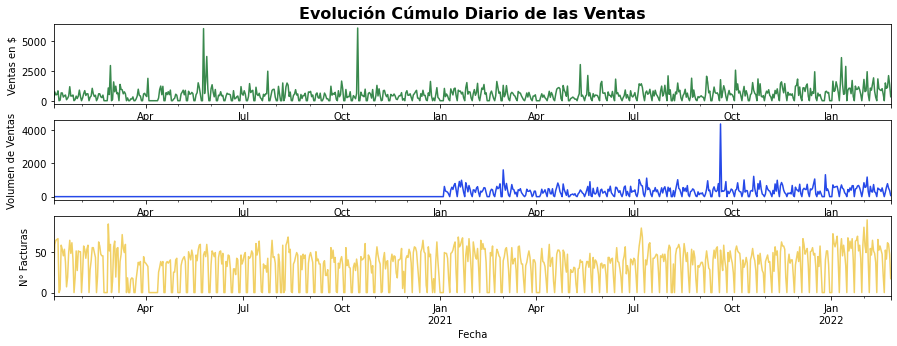

In [106]:


fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,5))

df_ventas_fecha.monto_dolar.resample('D').sum().plot(ax=ax1, color=VERDE)
df_ventas_fecha.cantidad.resample('D').sum().plot(ax=ax2, color=AZUL)
df_ventas_fecha.num.resample('D').sum().plot(ax=ax3, color=AMARILLO)
ax1.set_title('Evolución Cúmulo Diario de las Ventas', fontsize=16, weight='bold')
ax1.set_ylabel('Ventas en $')
ax2.set_ylabel('Volumen de Ventas')
ax3.set_ylabel('N° Facturas')
ax3.set_xlabel('Fecha')

In [110]:
df_ventas.query('cantidad == cantidad.max()')



,num,fecha_comp,vendedor,monto,tipo,cod,producto,cantidad,fecha,tasa_dolar,monto_dolar
38952,2021-0000002825-ne,2021-09-20 14:23:00,1,580.0,ne,02794,"ARANDELA PLANA 3/8"" NACIONAL TANQUE AUSTRALIANO",2000.0,2021-09-20,3.750547,154.644107


In [15]:
# Creamos una columna index para poder hacer un gráfico de regresión y ver la tendencia de las ventas diarias
df_ventas_dol_reg = df_ventas_fecha.monto_dolar.resample('D').sum().reset_index().reset_index()
df_ventas_dol_reg.sample(5)

,index,fecha,monto_dolar
708,708,2021-12-14,427.567164
201,201,2020-07-25,0.000000
264,264,2020-09-26,122.196078
561,561,2021-07-20,395.907255
672,672,2021-11-08,533.754505


Text(0.5, 0, 'N° Días')

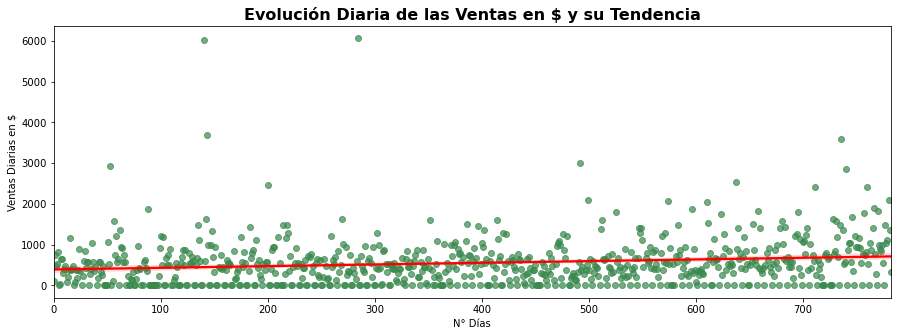

In [111]:
fig, ax = plt.subplots(figsize=(15,5))
sns.regplot(
    x='index',
    y='monto_dolar',
    data=df_ventas_dol_reg,
    scatter_kws={'color': VERDE, 'alpha': 0.7},
    line_kws={'color': 'red'},
)
ax.set_title(
    'Evolución Diaria de las Ventas en $ y su Tendencia',
    fontsize=16,
    weight='bold',
)
ax.set_ylabel('Ventas Diarias en $')
ax.set_xlabel('N° Días')

## 6. Ventas en USD<a name="ventas-usd"></a>

### 6.A Ventas Excepcionales<a name="ventas-excepcionales"></a>

Las **Ventas Excepcionales** son aquellas cuyos montos son excepcionalmente elevados. Son ventas reales, por lo tanto no pueden ser descartadas completamente.

Estudiarlas, equivale a estudiar los **outliers**.

In [17]:
# Calculamos el monto total por factura

df_total_factura = df_ventas.groupby('num').monto_dolar.sum()
df_total_factura = df_total_factura.reset_index()
df_total_factura.describe()

,monto_dolar
count,25878.000000
mean,16.698691
std,71.286925
min,0.000317
25%,1.925561
50%,4.985491
75%,12.777997
max,5686.278600


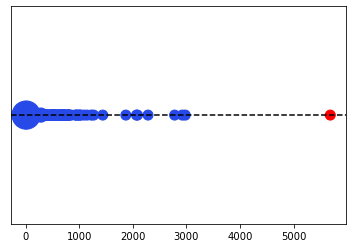

In [18]:
montos = np.array(df_total_factura.monto_dolar)
montos_unicos, counts = np.unique(montos, return_counts=True)
 
sizes = counts*100
colores = [AZUL]*len(montos_unicos)
colores[-1] = 'red'
 
plt.axhline(1, color='k', linestyle='--')
plt.scatter(montos_unicos, np.ones(len(montos_unicos)), s=sizes, color=colores)
plt.yticks([])
plt.show()

<AxesSubplot:xlabel='monto_dolar', ylabel='Density'>

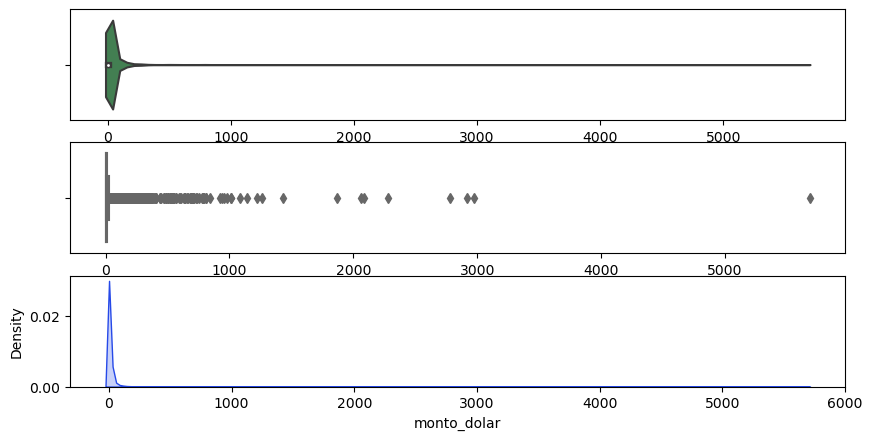

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, dpi=100, figsize=(10,5))

sns.violinplot(x='monto_dolar', data=df_total_factura, color=VERDE, ax=ax1)
sns.boxplot(x='monto_dolar', data=df_total_factura, color=AMARILLO, ax=ax2)
sns.kdeplot(x='monto_dolar', data=df_total_factura, color=AZUL, shade=True, ax=ax3)

In [20]:
df_total_factura_max = df_total_factura.query('monto_dolar > 1000.0')
df_total_factura_max.describe()

,monto_dolar
count,15.000000
mean,2055.794947
std,1225.904000
min,1015.451327
25%,1180.511252
50%,1866.830040
75%,2529.610593
max,5686.278600


1. La gran mayoría de las ventas no sobrepasa los 13 USD
2. Se observa un grupo que va hasta los 1.000 USD, luego dos pequeños grupos al rededor de los 2.000 USD y 3.000 USD
3. Hay un caso extremo que sobrepasa los 5.680 USD
4. Hay apenas 15 ventas con montos mayores a 1.000 USD, lo que equivale a 0,06% de las ventas. Haremos comparaciones entre los datos completos y los datos sin las ventas mayores a 1.000 USD

In [21]:
df_ventas_sin_excep = df_ventas[~df_ventas.num.isin(df_total_factura_max.num)].loc[:,['fecha', 'monto_dolar']]
df_ventas_sin_excep = df_ventas_sin_excep.groupby('fecha').monto_dolar.sum().reset_index()
df_ventas_sin_excep.sample(5)

,fecha,monto_dolar
153,2020-08-07,1479.949875
312,2021-03-01,1282.797023
315,2021-03-04,1258.638821
91,2020-05-12,553.226245
212,2020-10-26,607.767499


In [22]:
df_ventas_comparacion = pd.merge(df_ventas_dol, df_ventas_sin_excep, on='fecha')
df_ventas_comparacion.columns=['fecha', 'monto_dolar', 'monto_sin_ex']
df_ventas_comparacion = df_ventas_comparacion.set_index('fecha')
df_ventas_comparacion.sample(5)

,monto_dolar,monto_sin_ex
fecha,,
2020-09-18,172.419027,172.419027
2021-09-07,2038.773379,2038.773379
2020-11-04,393.706990,393.706990
2021-07-27,1218.296025,1218.296025
2020-08-13,358.353234,358.353234


Text(0, 0.5, 'Sin Ventas Excepcionales')

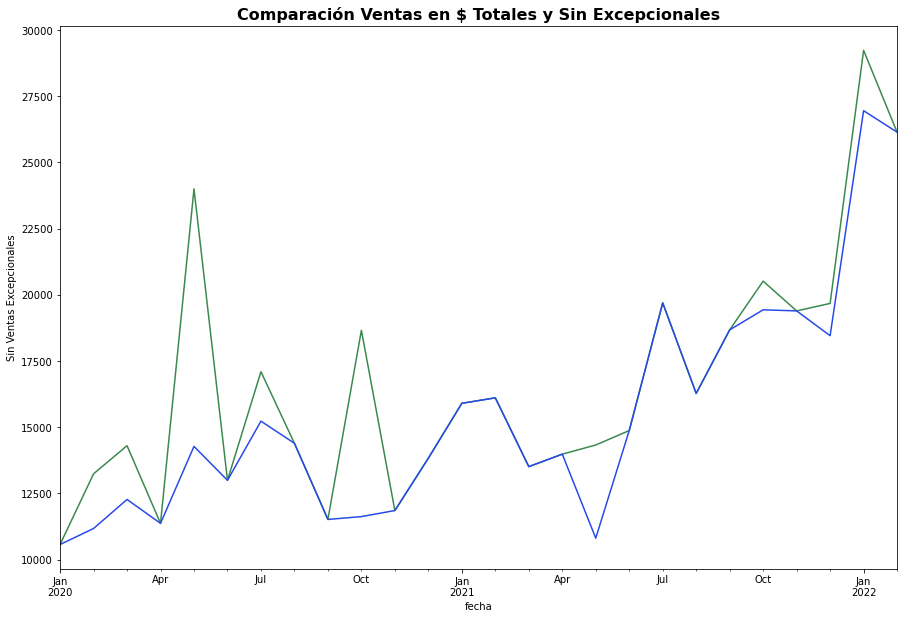

In [23]:
fig, ax = plt.subplots(figsize=(15,10))

df_ventas_comparacion.monto_dolar.resample('M').sum().plot(color=VERDE)
df_ventas_comparacion.monto_sin_ex.resample('M').sum().plot(color=AZUL)
ax.set_title('Comparación Ventas en $ Totales y Sin Excepcionales', fontsize=16, weight='bold')
ax.set_ylabel('Ventas Totales')
ax.set_ylabel('Sin Ventas Excepcionales')

In [24]:
df_ventas_comparacion.reset_index(inplace=True)

In [98]:
# Comparación total de ventas por año tomando en cuenta o no las ventas excepcionales

df_comparacion_año = df_ventas_comparacion.pivot_table(index=df_ventas_comparacion.fecha.dt.year,
                            aggfunc={'monto_dolar': sum, 'monto_sin_ex': sum})
df_comparacion_año['diferencia'] = df_comparacion_año.monto_dolar - df_comparacion_año.monto_sin_ex
df_comparacion_año.columns = ['Todas las Ventas', 'Sin Excepcionales', 'Diferencia']

formato_titulo('Comparación Anual del Total de Ventas en $ con y sin las Ventas Excepcionales')
prettify(df_comparacion_año, row_limit=5, col_limit=4, delay_time=1)


Comparación Anual del Total de Ventas en $ con y sin las Ventas Excepcionales



Output()

### 5.C Ventas por Fecha<a name="ventas-fecha"></a>

In [26]:
# Calculamos diferentes partes de la fecha

df_ventas_dol['año'] = df_ventas_dol.fecha.dt.year
df_ventas_dol['mes_año'] = df_ventas_dol.fecha.dt.strftime('%m-%Y')
df_ventas_dol['dia_semana'] = df_ventas_dol.fecha.dt.weekday
df_ventas_dol['dia_mes'] = df_ventas_dol.fecha.dt.day
df_ventas_dol.sample(5)

,fecha,monto_dolar,año,mes_año,dia_semana,dia_mes
254,2020-12-15,365.142606,2020,12-2020,1,15
41,2020-02-21,468.603665,2020,02-2020,4,21
256,2020-12-17,441.031125,2020,12-2020,3,17
243,2020-12-02,450.752098,2020,12-2020,2,2
286,2021-01-26,1511.613371,2021,01-2021,1,26


In [73]:
lineas = alt.Chart(df_ventas_dol).mark_bar().encode(
    x='month(fecha):T',
    y='sum(monto_dolar):Q',
    color=alt.Color('año:N', scale=alt.Scale(domain=AÑOS, range=COLORES)),
    tooltip=[
        alt.Tooltip('yearmonth(fecha):T', title='Fecha'),
        alt.Tooltip('sum(monto_dolar):Q', title='Ventas en $'),
        alt.Tooltip('sum(cantidad):Q', title='Volumen de Venta')
    ]).properties(width=800, height=200)

lineas

alt.Chart(...)

In [74]:
barras = alt.Chart(df_ventas_dol).mark_bar().encode(
                x=alt.X('yearmonth(fecha):T', title='Días de la Semana', axis = alt.Axis(labelAngle=0, labelFontSize=14)),
                y=alt.Y('sum(monto_dolar):Q', title = 'Ventas en $', scale=alt.Scale(zero=False), 
                  axis = alt.Axis(grid=True, titleAnchor='middle', titleAngle = 270, labelFontSize=10)),
                color=alt.Color(
                    'sum(monto_dolar):Q', scale=alt.Scale(scheme='goldgreen')),
                tooltip=[
                    alt.Tooltip('yearmonth(fecha):T', title='Día'),
                    alt.Tooltip('sum(monto_dolar):Q', title='Ventas en $'),
                    alt.Tooltip('sum(cantidad):Q', title='Volumen de Venta')],
                ).properties(title='Ventas en $ por Mes',
                             width=700, 
                             height=300
                ).configure_title(
                    fontSize = 16,
                    anchor = 'middle',
                ).interactive()
barras

alt.Chart(...)

#### 5.C.a Ventas por Día de la Semana<a name="ventas-dia-semana"></a>

In [75]:
# Total de ventas por día de la semana de cada mes

df_ventas_dia_semana = df_ventas_dol.pivot_table(index=df_ventas_dol.mes_año,
                                            columns=df_ventas_dol.dia_semana, aggfunc={'monto_dolar': sum},
                                            fill_value=0)
df_ventas_dia_semana.columns = ['Lun', 'Mar', 'Mie', 'Jue', 'Vie', 'Sab', 'Dom']
df_ventas_dia_semana

,Lun,Mar,Mie,Jue,Vie,Sab,Dom
mes_año,,,,,,,
01-2020,1531.657232,2730.974894,1557.202647,2207.919301,2123.907868,82.358816,333.857234
01-2021,2950.556683,4039.964339,2166.060704,2864.239439,2884.332234,996.294727,0.000000
01-2022,5993.008193,6345.862615,4211.000312,3849.191008,4383.430025,4456.175386,0.000000
02-2020,1563.447720,2453.311830,2397.020698,1701.697084,4424.442111,0.000000,697.923364
02-2021,1559.886233,3585.569561,3141.892730,3451.844984,3229.538314,1140.054082,0.000000
02-2022,4354.673485,4685.985489,4181.568520,5679.147656,5564.711846,1679.668989,0.000000
03-2020,3220.645464,2652.192226,2903.512438,1892.565451,1937.839969,0.000000,1693.889650
03-2021,3298.064658,2713.807813,2568.880136,2812.007238,1635.795558,480.829274,0.000000
04-2020,1027.444224,1645.236462,2942.525720,1801.916525,3949.732841,0.000000,0.000000


In [78]:
mapa = alt.Chart(df_ventas_dol).mark_rect().encode(
                x=alt.X('day(fecha):T', title='Días de la Semana', axis = alt.Axis(labelAngle=0, labelFontSize=14)),
                y=alt.Y('yearmonth(fecha):T', title = 'Ventas en $', scale=alt.Scale(zero=False), 
                  axis = alt.Axis(grid=True, titleAnchor='middle', titleAngle = 270, labelFontSize=10)),
                color=alt.Color('sum(monto_dolar):Q', scale=alt.Scale(scheme='goldgreen')),
                tooltip=[
                    alt.Tooltip('day(fecha):T', title='Día'),
                    alt.Tooltip('yearmonth(fecha):T', title='Mes y Año'),
                    alt.Tooltip('sum(monto_dolar):Q', title='Ventas en $')]
                ).properties(title='Ventas en $ por Día de la Semana',
                             width=600, 
                             height=300
                ).configure_title(
                    fontSize = 16,
                    anchor = 'middle',
                ).interactive()

mapa

alt.Chart(...)

In [77]:
barras = alt.Chart(df_ventas_dol).mark_bar().encode(
                x=alt.X('day(fecha):T', title='Días de la Semana', axis = alt.Axis(labelAngle=0, labelFontSize=14)),
                y=alt.Y('sum(monto_dolar):Q', title = 'Ventas en $', scale=alt.Scale(zero=False), 
                  axis = alt.Axis(grid=True, titleAnchor='middle', titleAngle = 270, labelFontSize=10)),
                color=alt.Color(
                    'sum(monto_dolar):Q', scale=alt.Scale(scheme='goldgreen')),
                tooltip=[
                    alt.Tooltip('day(fecha):T', title='Día'),
                    alt.Tooltip('sum(monto_dolar):Q', title='Ventas en $')],
                ).properties(title='Ventas en $ por Día de la Semana',
                             width=600, 
                             height=300
                ).configure_title(
                    fontSize = 16,
                    anchor = 'middle',
                ).interactive()
barras

alt.Chart(...)

#### 5.C.b Ventas por Día del Mes<a name="ventas-dia-mes"></a>

In [32]:
df_ventas_dia_mes = df_ventas_dol.pivot_table(index=df_ventas_dol.mes_año,
                                            columns=df_ventas_dol.dia_mes, aggfunc={'monto_dolar': sum},
                                            fill_value=0)
df_ventas_dia_mes

monto_dolar                                                      \
dia_mes           1            2            3            4            5    
mes_año                                                                    
01-2020     0.000000     0.000000     0.000000     0.000000     0.000000   
01-2021     0.000000     0.000000     0.000000     0.000000  1025.174371   
01-2022     0.000000     0.000000  1628.923241   773.260504   854.500000   
02-2020     0.000000   228.427405   591.898212   840.911939   434.875294   
02-2021   597.742987   928.112308   448.788414   676.658349  1448.390864   
02-2022  1775.049041   757.390192   831.203863  2420.160870   520.167391   
03-2020   102.471183  1569.100584   740.156960  1213.586690   581.002611   
03-2021  1282.797023   327.117997   521.856075  1258.638821   606.867712   
04-2020   429.947573   343.727378  1865.040038     0.000000     0.000000   
04-2021     0.000000     0.000000     0.000000     0.000000   310.550924   
05-2020     0.000000     0.000000     0.000000   559.629421   708.440722   
05-2021     0.000000     0.000000   179.121985   229.004501   303.164561   
06-2020   984.311972  1332.024144   696.307495   323.136042   935.775980   
06-2021  1610.459773   645.720572   618.434072   660.443987   176.276599   
07-2020   460.703161   830.441806   554.543131     0.000000     0.000000   
07-2021   449.820795   670.552823   205.902734     0.000000   665.648431   
08-2020     0.000000     0.000000  1197.170954   556.828608     0.000000   
08-2021     0.000000  2076.398369   532.983106   908.458977     0.000000   
09-2020   696.059023   780.140801   336.050436   478.429830     0.000000   
09-2021   351.150160   407.752358   306.196339   286.529001     0.000000   
10-2020  1637.070887  1010.448421     0.000000     0.000000   938.159789   
10-2021   489.654244   302.497817     0.000000  2547.654501   889.681818   
11-2020     0.000000   421.493914  1279.945126   393.706990   992.169576   
11-2021   511.719101   795.961538   634.821670   915.937639   444.185268   
12-2020   834.225726   450.752098   456.728855   577.661259   289.318192   
12-2021  1804.950207   437.373695  1142.676471   262.088050     0.000000   

                                                                          ...  \
dia_mes           6            7            8            9            10  ...   
mes_año                                                                   ...   
01-2020   104.610817   739.473869   485.385935   515.495960   823.755195  ...   
01-2021   338.556452   559.099981   406.877705   113.560197     0.000000  ...   
01-2022  1579.416327  1191.730392   698.201474     0.000000  1482.000000  ...   
02-2020   582.694724   568.515668     0.000000   288.046326   395.750196  ...   
02-2021   285.706649     0.000000   528.333392  1052.128996   945.011517  ...   
02-2022     0.000000  1052.950108   879.565217  1401.104575  1905.677560  ...   
03-2020   646.227529     0.000000  1359.571616   940.063855   918.230849  ...   
03-2021   138.317334     0.000000   566.644612   696.262891   616.013044  ...   
04-2020     0.000000     0.000000     0.000000     0.000000     0.000000  ...   
04-2021   577.616637   288.305906   468.976941   244.816049   144.322024  ...   
05-2020   878.469839   492.796971   864.247780     0.000000     0.000000  ...   
05-2021   229.910797   125.169426   138.451233     0.000000   337.713740  ...   
06-2020     0.000000     0.000000   462.697836   422.152875   749.672755  ...   
06-2021     0.000000   732.745323   457.801844   438.424317   296.985811  ...   
07-2020   357.390229  1427.228788   680.721010   798.203946   871.979596  ...   
07-2021  1407.765877  1281.355950  1413.361915  1104.303772   448.666178  ...   
08-2020     0.000000  1479.949875     0.000000   276.899321  1156.194226  ...   
08-2021     0.000000   536.191117     0.000000   720.760998   567.037550  ...   
09-2020     0.000000   543.376057   648.269859   256.875271   204.540011  ...   
09-2021   493.153545  

In [80]:
mapa = alt.Chart(df_ventas_dol).mark_rect().encode(
                x=alt.X('dia_mes:O', title='Días del mes', axis = alt.Axis(labelAngle=0, labelFontSize=14)),
                y=alt.Y('yearmonth(fecha):T', title = 'Mes y Año', scale=alt.Scale(zero=False), 
                  axis = alt.Axis(grid=True, titleAnchor='middle', titleAngle = 270, labelFontSize=10)),
                color=alt.Color(
                    'sum(monto_dolar):Q', scale=alt.Scale(scheme='goldgreen')),
                tooltip=[
                    alt.Tooltip('dia_mes:O', title='Día'),
                    alt.Tooltip('yearmonth(fecha):T', title='Mes y Año'),
                    alt.Tooltip('sum(monto_dolar):Q', title='Ventas en $')]
                ).properties(title='Ventas en $ por Día del Mes',
                             width=800, 
                             height=300
                ).configure_title(
                    fontSize = 16,
                    anchor = 'middle',
                ).interactive()

mapa

alt.Chart(...)

In [81]:
barras = alt.Chart(df_ventas_dol).mark_bar().encode(
                x=alt.X('dia_mes:O', title='Días de la Semana', axis = alt.Axis(labelAngle=0, labelFontSize=14)),
                y=alt.Y('sum(monto_dolar):Q', title = 'Ventas en $', scale=alt.Scale(zero=False), 
                  axis = alt.Axis(grid=True, titleAnchor='middle', titleAngle = 270, labelFontSize=10)),
                color=alt.Color(
                    'sum(monto_dolar):Q', scale=alt.Scale(scheme='goldgreen')),
                tooltip=[
                    alt.Tooltip('dia_mes:O', title='Día'),
                    alt.Tooltip('sum(monto_dolar):Q', title='Ventas en $')],
                ).properties(title='Ventas en $ por Día del Mes',
                             width=800, 
                             height=300
                ).configure_title(
                    fontSize = 16,
                    anchor = 'middle',
                ).interactive()
barras

alt.Chart(...)

## 6. Ventas por Línea de Producto<a name="ventas-linea"></a>

### 6.A Resumen General<a name="resumen-general-volumen"></a>

In [35]:
df_linea = df_ventas_linea_prod.copy()
df_linea['mes_año'] = df_linea.fecha.dt.strftime("%m-%Y")
df_linea.dropna(inplace=True)
df_linea.sample(5)

,fecha,cod,producto,cantidad,monto_dolar,linea,stock,fecha_stock,mes_año
17875,2022-01-19,03810,"LLAVE CHORRO 1/2"" BRONCE GRINACA CON CONEXION ...",1.0,10.208333,LLAVES O VALVULAS METALICAS,8.0,2022-03-03,01-2022
10125,2022-02-08,00319,"ANILLO HG 2""",1.0,5.054348,CONEXIONES GALVANIZADAS Y CROMADAS,50.0,2022-03-03,02-2022
2554,2022-02-24,00776,BOLSA PLASTICA PEQUEÑA 10KRGS (USO INTERNO) UN...,1.0,0.013100,GENERALES,631.0,2022-03-03,02-2022
27376,2021-10-25,04793,"BROCHA 5"" AMARILLA",1.0,4.046512,HERRAMIENTAS MANUALES,0.0,2022-03-03,10-2021
16026,2021-11-29,05292,"BUSINHG PLASTICO REDUCIDO 1 1/2"" * 1 1/4"" GRI...",1.0,0.704225,TUBERIAS AGUAS BLANCAS PLASTICAS Y GALVANIZADAS,40.0,2022-03-03,11-2021


### 6.B Productos con Ventas Numerosas<a name="ventas-numerosas"></a>

In [36]:
df_cantidad = pd.DataFrame(df_ventas.cantidad.value_counts())

df_cantidad.reset_index(inplace=True)
df_cantidad.columns = ['cant_venta', 'cantidad']
df_cantidad.describe()

,cant_venta,cantidad
count,246.000000,246.000000
mean,62.906870,176.776423
std,176.276359,1403.517617
min,0.000000,1.000000
25%,1.102500,1.000000
50%,7.125000,2.000000
75%,57.750000,5.000000
max,2000.000000,18398.000000


In [109]:
cantidades = np.array(df_total_factura.cantidad)
cantidades_unicas, counts = np.unique(cantidades, return_counts=True)
 
sizes = counts*100
colores = [AZUL]*len(cantidades_unicas)
colores[-1] = 'red'
 
plt.axhline(1, color='k', linestyle='--')
plt.scatter(cantidades_unicas, np.ones(len(cantidades_unicas)), s=sizes, color=colores)
plt.yticks([])
plt.show()

AttributeError: 'DataFrame' object has no attribute 'cantidad'

<AxesSubplot:xlabel='cant_venta', ylabel='Density'>

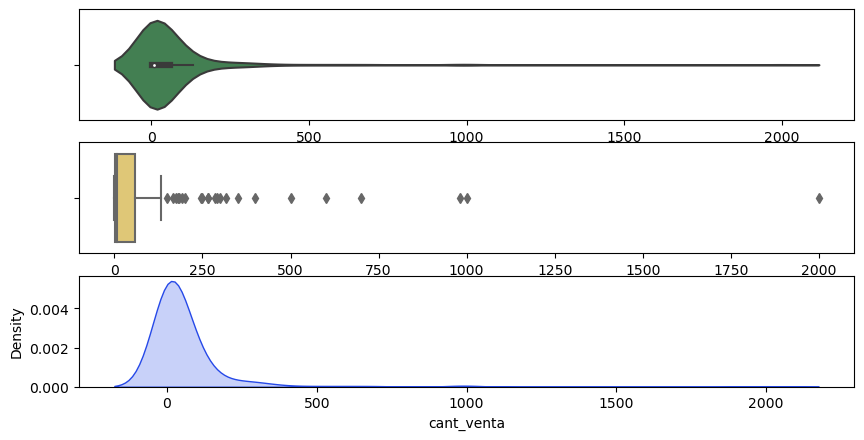

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, dpi=100, figsize=(10,5))

sns.violinplot(x='cant_venta', data=df_cantidad, color=VERDE, ax=ax1)
sns.boxplot(x='cant_venta', data=df_cantidad, color=AMARILLO, ax=ax2)
sns.kdeplot(x='cant_venta', data=df_cantidad, color=AZUL, shade=True, ax=ax3)

### 6.C Líneas de Producto más Vendidas en USD y en Volumen<a name="linea-mas-vendidos"></a>    

In [38]:
# Por cada línea de producto: Ventas en volumen (cantidad), N° de productos (producto) 
# y total de Ventas en $ (monto_dolar)
df_linea_general = df_linea.pivot_table(index='linea',
                                        aggfunc={'monto_dolar':sum,
                                                 'producto':'nunique',
                                                 'cantidad':sum})
# Definimos la columna rango para seleccionar las 15 líneas con más ventas en $ y/o volumen
df_linea_general['rango'] = df_linea_general.cantidad + df_linea_general.monto_dolar

df_linea_general.cantidad = round(df_linea_general.cantidad, 2)
df_linea_general.monto_dolar = round(df_linea_general.monto_dolar, 2)

df_linea_general.columns=['Volumen Ventas', 'Ventas en $', 'N° Productos', 'rango']

df_linea_general = df_linea_general.sort_values(['rango'], ascending=False)

prettify(df_linea_general, row_limit=45, col_limit=4, delay_time=1)

Output()

In [39]:
df_linea_top_15 = df_linea_general.reset_index().sort_values(['rango'], ascending=False).head(15)


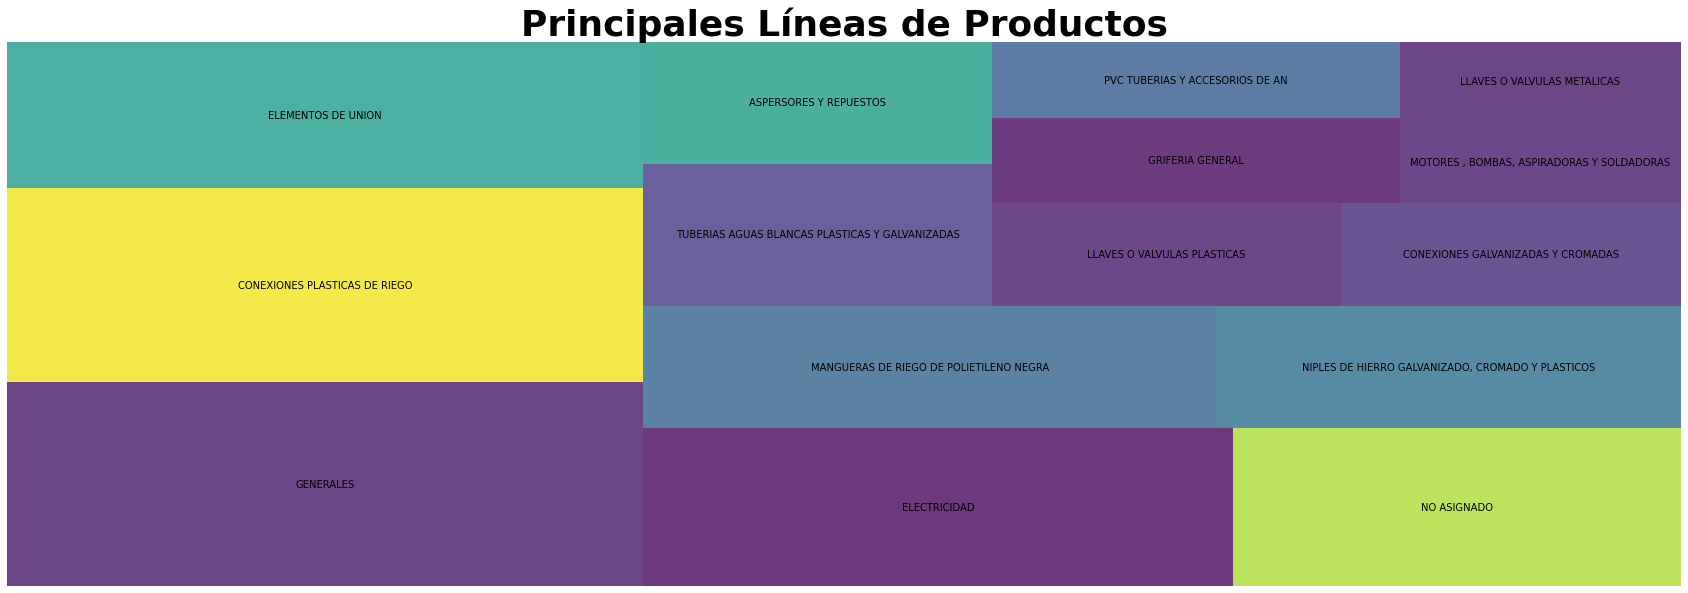

In [40]:
with plt.style.context('seaborn-colorblind'):

    fig, ax = plt.subplots(figsize=(30,10))

    labels = df_linea_top_15['linea']
    sizes = df_linea_top_15['rango']
    squarify.plot(sizes, label=labels, alpha=0.8)

    plt.title('Principales Líneas de Productos',fontsize=36, fontweight='bold') 
    plt.axis('off')
    plt.show()

In [41]:
base = alt.Chart(df_linea_top_15).encode(
    theta=alt.Theta("rango:Q", stack=True), color=alt.Color("linea:N")
)

pie = base.mark_arc(outerRadius=180)
text = base.mark_text(radius=180, size=10).encode(text="linea:N")

pie + text

alt.LayerChart(...)

In [88]:
base = alt.Chart(df_linea_top_15).encode(
    theta=alt.Theta("rango:Q", stack=True),
    radius=alt.Radius("rango", scale=alt.Scale(type="sqrt", zero=True, rangeMin=20)),
    color="linea:N",
)

c1 = base.mark_arc(innerRadius=30, stroke="#fff")

c2 = base.mark_text(radiusOffset=20).encode(text="rango:Q")

c1 + c2

alt.LayerChart(...)

In [43]:
df_generales = df_linea.query('linea == "GENERALES"').groupby(['cod', 'producto']).cantidad.count()
df_generales.sort_values(ascending=False).head(60)

cod    producto                                                                          
00776  BOLSA PLASTICA PEQUEÑA 10KRGS (USO INTERNO) UNIDAD                                    1717
01214  BOLSA PLASTICA GRANDE 20 Y 25 kgrs (USO INTERNO) UNIDAD                                316
00233  SOLDADURA 3/32 FINA AZUL WEST ARCO KILO(60VARILLAS)                                    296
05102  COPIA DE LLAVE                                                                         227
00028  TEFLON PROF 1/2 * 10mts SUPER EXTRA LUZ/P.T.F.E                                        155
00500  TEIPE ELECTRICO 3/4"*18MTS  NEGRO COBRA                                                131
02372  PEGATANKE EPOXI 30 MINUTOS ORIGINAL/BLANCA/ACERO/TRANSPARENTE 44G                       44
00001  PEGA DE CONTACTO/PEGA ZAPATERA (90 ML) ENVASADO                                         43
02494  ABRAZADERA METALICA 17-18MM TIPO TORNILLO SIN FIN                                       42
03577  BOLSA AZUL CEMENTO   

In [44]:
df_no_asignado = df_linea.query('linea == "NO ASIGNADO"').groupby(['cod', 'producto']).cantidad.count()
df_no_asignado.sort_values(ascending=False).head(60)

cod    producto                                                                 
00365  DISCO 4 1/2" CORTE EXTRAFINO METAL PRETUL DICOF-4510P                        178
01292  YESQUERO UNIVERSAL                                                           138
00792  SOCATE O BOQUILLA DE PORCELANA E27 CON ROSCA                                  83
00086  REGADOR 1/2" NEGRO PLASTICO BOQUILLAS COLORES DOBLE CHORRO 9-12M DIAMETRO     63
01048  CLAVO 2*10 ACERO POR UNIDAD                                                   60
00802  TEIPE ELECTRICO 3/4"*10MTS  NEGRO COBRA ORIGINAL                              60
05103  CONFITERIA PAPAS FRITAS MARGARITA                                             52
01782  CLAVO ACERO 2 1/2 RANURADO (POR UNIDAD)173 KILO                               47
01018  CONFITERIA HALLS 1 CARAMELO                                                   45
00891  CONFITERIA CHOCO DISK                                                         38
01716  MASCARILLA KN95 BLANCA/COLORES  

In [45]:
# Los 5 productos con mayores ventas en $ por cada línea

df_ventas_linea_mont = df_linea.pivot_table(index=['linea', 'producto'],
                                       aggfunc={'monto_dolar':sum})

df_ventas_linea_mont = df_ventas_linea_mont.monto_dolar.groupby('linea', group_keys=False)

df_ventas_linea_mont = df_ventas_linea_mont.nlargest(5)

df_ventas_linea_mont = df_ventas_linea_mont.reset_index()

df_ventas_linea_mont

,linea,producto,monto_dolar
0,ALAMBRES Y MALLAS,ALAMBRE C-17.5 LISO HG KILOGRAMO VICSON,892.187305
1,ALAMBRES Y MALLAS,ALAMBRE DE PUAS CALIBRE 16 400 MTRS TREXA,302.372590
2,ALAMBRES Y MALLAS,ALAMBRE DE PUAS CALIBRE 15.5 METROS 500 IMPORTADO,260.299266
3,ALAMBRES Y MALLAS,ALAMBRE DE PUAS CALIBRE 15 METROS 500 MOTTO VI...,192.911705
4,ALAMBRES Y MALLAS,"MALLA METALICA GALLINERA 2"" *1.65 *30 C-22 (...",147.157644
...,...,...,...
159,TUBERIAS AGUAS BLANCAS PLASTICAS Y GALVANIZADAS,"ANILLO REDUCIDO 3/4""*1/2"" PLASTICO ROSCADO BLA...",1256.646569
160,TUBERIAS AGUAS BLANCAS PLASTICAS Y GALVANIZADAS,"TUBO PLASTICO 3/4""*6MTS AZUL SHEDULE INPLAVEN",1244.181301
161,TUBERIAS AGUAS BLANCAS PLASTICAS Y GALVANIZADAS,"TUBO PLASTICO 1/2""*6MTS AZUL SHEDULE INPLAVEN",1229.302186
162,TUBERIAS AGUAS BLANCAS PLASTICAS Y GALVANIZADAS,"TUBO PLASTICO 1""*6MTS AZUL SCHEDULE INPLAVEN",731.372797


In [46]:
# Los 5 productos con mayores volúmenes de venta por cada línea

df_ventas_linea_cant = df_linea.pivot_table(index=['linea', 'producto'],
                                       aggfunc={'cantidad':sum} )

df_ventas_linea_cant = df_ventas_linea_cant.cantidad.groupby('linea', group_keys=False)

df_ventas_linea_cant = df_ventas_linea_cant.nlargest(5)

df_ventas_linea_cant = df_ventas_linea_cant.reset_index()

df_ventas_linea_cant.set_index('linea', inplace=True)

df_ventas_linea_cant

,producto,cantidad
linea,,
ALAMBRES Y MALLAS,ALAMBRE C-17.5 LISO HG KILOGRAMO VICSON,218.25
ALAMBRES Y MALLAS,"MALLA METALICA GALLINERA 2"" *1.65 *30 C-22 (...",62.40
ALAMBRES Y MALLAS,"MALLA METALICA POLLITO 1"" *0.9*25 C-22 (POR M...",57.90
ALAMBRES Y MALLAS,ALAMBRE C-17.5 LISO HG KILOGRAMO IMPORTADO,41.00
ALAMBRES Y MALLAS,ALAMBRE C-14 LISO HG BOBINA DE 50 KG VICSON (P...,18.17
...,...,...
TUBERIAS AGUAS BLANCAS PLASTICAS Y GALVANIZADAS,"ANILLO 1/2"" PLASTICO ROSCADO BLANCO",1372.00
TUBERIAS AGUAS BLANCAS PLASTICAS Y GALVANIZADAS,"ANILLO REDUCIDO 1"" * 3/4"" PLASTICO ROSCADO BLANCO",474.00
TUBERIAS AGUAS BLANCAS PLASTICAS Y GALVANIZADAS,"BUSINHG PLASTICO REDUCIDO 3/4"" * 1/2"" AZUL/BL...",241.00


## 7. Ventas por Producto<a name="ventas-producto"></a>

In [47]:
df_ventas_prod = df_ventas_linea_prod.copy()
df_ventas_prod.sample(5)

,fecha,cod,producto,cantidad,monto_dolar,linea,stock,fecha_stock
16133,2021-01-12,06102,"RIEGO ADAPTADOR HEMBRA 32 MM * 3/4"" AGRO/ F.P/MOM",2.0,1.512852,CONEXIONES PLASTICAS DE RIEGO,294.0,2022-03-03
4659,2022-01-05,02257,"RIEGO ABRAZADERA PLASTICA 50MM * 1"" AGRO/FP/MOM",1.0,2.717842,CONEXIONES PLASTICAS DE RIEGO,205.0,2022-03-03
9613,2021-10-14,01841,"LLAVE PLASTICA 1 1/2"" ROSCADA",30.0,77.395577,LLAVES O VALVULAS PLASTICAS,36.0,2022-03-03
27249,2021-03-03,01516,CABLE SPT 2*12 SPT BLANCO 100% COBRE,5.5,11.686642,NaN,NaN,NaT
1859,2022-02-16,00415,"ANILLO HG 1/2""",1.0,0.258134,CONEXIONES GALVANIZADAS Y CROMADAS,445.0,2022-03-03


### 7.A Productos sin Ventas<a name="prod-sin-ventas"></a>

In [48]:
# Productos sin ventas
filtro = df_ventas_linea_prod['cantidad'].isna() & df_ventas_linea_prod['stock'] > 0

df_ventas_linea_prod[filtro][ ['linea', 'cod', 'producto', 'stock'] ].sort_values('stock', ascending=False)

,linea,cod,producto,stock
32755,ASPERSORES Y REPUESTOS,00844,R. ACOPLE RAB DOBLE BAJO PARA MICROASPERSOR,8045.00
32756,ASPERSORES Y REPUESTOS,00845,R. ACOPLE RAB LISO ALTO PARA MICROASPERSOR,7600.00
33149,ELEMENTOS DE UNION,03466,"TORNILLO DRYWALL Nº 6 * 1""",3465.00
32758,MANGUERAS GENERALES NO DE POLIETILENO,00847,MANGUERA 7MM PARA MICROASPERSOR POR METRO/ROLL...,1883.00
33599,ELEMENTOS DE UNION,05608,"TORNILLO 10*2 1/2"" AUTOROSCANTE ESTRIA",500.00
...,...,...,...,...
33371,GENERALES,04585,R. PRESOTATO PARA COMPRESOR 15-40 PSI SACO,1.00
32857,ELECTRICIDAD,01198,PROTECTOR DE LAVADORA XYS PROTECTOR 128,1.00
33135,SEGURIDAD & HIGIENE,03255,BOTAS #38 DE CAUCHO CAÑA CORTA BEIGE SEA,1.00
33020,GENERALES,01787,"TUBO PLASTICO 2 1/2""*6 MTS SCHEDULE 80 AZUL UR...",0.98


Existen más de 1.000 productos en existencia y sin ventas.

Para algunos es normal ya que se trata de productos relativamente nuevos. Es necesario cruzar la información con la última fecha de entrada en stock (no presente en los datos) para determinar realmente los productos que no se venden.

Una vez identificados estos productos, es necesario idear estrategias para venderlos: Promociones, rifas, etc.

Además, deberán ser identificados para no adquirirlos de nuevo.

### 7.B Productos más Vendidos<a name="prod-mas-vendidos"></a>

In [49]:
# Por cada línea de producto: Ventas en volumen (cantidad), N° de productos (producto) 
# y total de Ventas en $ (monto_dolar)
df_prod_general = df_ventas_prod.pivot_table(index=['cod', 'producto'],
                                        aggfunc={'monto_dolar':sum,
                                                 'cantidad':sum})
# Definimos la columna rango para seleccionar las 15 líneas con más ventas en $ y/o volumen
df_prod_general['rango'] = df_prod_general.cantidad + df_prod_general.monto_dolar

df_prod_general.cantidad = round(df_prod_general.cantidad, 2)
df_prod_general.monto_dolar = round(df_prod_general.monto_dolar, 2)

df_prod_general.columns=['Volumen Ventas', 'Ventas en $', 'rango']

df_prod_general = df_prod_general.sort_values(['rango'], ascending=False)

formato_titulo('Productos más Vendidos por Volumen de Ventas y/o Ventas en $')

table = prettify(df_prod_general, row_limit=100, col_limit=4, delay_time=1)

Productos más Vendidos por Volumen de Ventas y/o Ventas en $



Output()

### 7.C Productos Indispensables<a name="prod-indispensables"></a>

Se trata de aquellos productos que se venden regularmente. Podría haber algunos meses sin ventas debido a una rotura de stock o que sean productos recientemente incorporados.

In [50]:
df_ventas_prod['mes_año'] = df_ventas_prod.fecha.dt.strftime('%m-%Y')

In [51]:
df_ventas_prod_mes = df_ventas_prod.pivot_table(index='cod',
                                               columns='mes_año',
                                               fill_value=0,
                                               aggfunc={'cantidad':sum})
df_ventas_prod_mes.sample(5)

cantidad                                                          \
mes_año  01-2021 01-2022 02-2021 02-2022 03-2021 04-2021 05-2021 06-2021   
cod                                                                        
03031        3.0     0.0     2.0     0.0     1.0     2.0     1.0     1.0   
00398        0.0    16.7     0.0     0.0     0.0     0.0     0.0     0.0   
02536        0.0     0.0     0.0     0.0     0.0     0.0     0.0     6.0   
01073        0.0     0.0     0.0     0.0     0.0     0.0     0.0     3.0   
02973        0.0     0.0     1.0     7.0     0.0     0.0     0.0     0.0   

                                                         
mes_año 07-2021 08-2021 09-2021 10-2021 11-2021 12-2021  
cod                                                      
03031       0.0    2.00     0.0     2.0     2.0     0.0  
00398       0.0   14.25     0.0     2.0     7.0     4.0  
02536       0.0    0.00     1.0     0.0     3.0     0.0  
01073       0.0    0.00     0.0     0.0     0.0     0.0  
02973       0.0    2.00     0.0     0.0     0.0     0.0

In [52]:
# Calculamos cuantos meses del período cada producto tuvo ventas
# Difinimos como un producto indispensable aquel que tiene ventas regulares
# por ejemplo el 75% de los meses del período

def calculo_mes_con_ventas(row):
    total = 0
    
    for column in row: 
        if column:
            total = total + 1
    
    return total

df_ventas_prod_mes['mes_ventas'] = df_ventas_prod_mes.apply(lambda row: calculo_mes_con_ventas(row), 
                                              axis = 1)

min_meses = df_ventas_prod['mes_año'].nunique() * .75

df_ventas_prod_mes = df_ventas_prod_mes[ df_ventas_prod_mes['mes_ventas'] > min_meses ]

df_ventas_prod_mes.sample(50)

cantidad                                                          \
mes_año  01-2021 01-2022 02-2021 02-2022 03-2021 04-2021 05-2021 06-2021   
cod                                                                        
00776      167.0   209.0    69.0   177.0    98.0    72.0   75.00   79.00   
00289        0.0     2.0     0.0     1.0    26.0    46.0   35.00    5.00   
02588       20.0    66.0    11.0   126.0    16.0   122.0   44.00   42.00   
02257       91.0   111.0    59.0    76.0    15.0    29.0   31.00   17.00   
01214       27.0    19.0    66.0    20.0    39.0    52.0   38.00   16.00   
01826        8.0    37.0    36.0    48.0    10.0     5.0   26.00    3.00   
00010        8.0     6.0    10.0     2.0     8.0     9.0    8.00    1.00   
01151        2.0     1.0     0.0     2.0     0.0     1.0    2.00    9.00   
00773        3.0     9.0     1.0     6.0     6.0     5.0    2.00    0.00   
00577       45.0    26.0     0.0     1.0     2.0     0.0    0.00    1.00   
04460        4.0     0.0    11.0    10.0    31.5    11.8    2.00   15.00   
01593        4.0     5.0     1.0     5.0     3.0     0.0    0.00    0.00   
00396        8.0    17.0    16.0     2.0     3.0     3.0   16.00    0.00   
01065        0.0     2.0     0.0     4.0     6.0     2.0    5.00    4.00   
00008        6.0    42.0     4.0    12.0     1.0     1.0    7.25   21.00   
00403        1.0     3.0     0.0     2.0     2.0     0.0    1.00    3.00   
05102        0.0    31.0    19.0     2.0    45.0    53.0   21.00   25.00   
02723        8.0    12.0    26.0    21.0     2.0     5.0   11.00    4.00   
06300       16.0     3.0     0.0    14.0     3.0     0.0   20.00    4.00   
04378       41.0    25.0     9.0    29.0     5.0    37.0    4.00   28.00   
02407       26.0     2.0    21.0     0.0    10.0     0.0    0.00   26.00   
03454        7.0     1.0     6.0     4.0    12.0     8.0    5.00    1.00   
00028       13.0    26.0    10.0    10.0     9.0     6.0    8.00    6.00   
06106        2.0     2.0     0.0     1.0     0.0     2.0    6.00    3.00   
03810       15.0    10.0    10.0     8.0    15.0    20.0   10.00    6.00   
02494        0.0    26.0    10.0    11.0    10.0     5.0    0.00    2.00   
00122       95.0   106.0   123.0   297.0   234.0    61.0   13.00   29.00   
03592       43.0     8.0     0.0    18.0    83.0    65.0   45.00   40.00   
01394        1.0     6.0    17.0     0.0    20.0    12.0    6.00   38.00   
00800        9.0    13.0     1.0     9.0    22.0    10.0    4.00    0.00   
00696        6.0     0.0     8.0     1.0     9.0     4.0    4.00    5.00   
03335        0.0    16.0     5.0     8.0    21.0    10.0   14.00    0.00   
00241       40.0     3.0     8.0     7.0     3.0    12.0    5.00    4.00   
00005        0.0   111.0     7.0    36.0    59.0    54.0   14.00   23.00   
01655        4.0     8.0     5.0     1.0     6.0     4.0   10.00    1.00   
00865        0.0     2.0     4.0     2.0     1.0     0.0    0.00    2.00   
04498        9.0     6.0    21.0     3.0     0.0     5.0    1.00    4.00   
04456        0.0   119.0     0.0    29.0     0.0     7.0   30.00    3.00   
06102       11.0     4.0    25.0     9.0     6.0    11.0   11.00    2.00   
00837        8.0     7.0     0.0     2.0    10.0     3.0    1.00    2.00   
01601       84.0    10.0    22.0    84.0   148.0   226.0   16.00   51.00   
01497        3.0    13.0    17.0    12.0     3.0     0.0    9.00   10.00   
06114       42.9     6.1     0.0    13.0     0.2     0.0    6.00   22.25   
01017       14.0     0.0    13.0     1.0    10.0     1.0    1.00    0.00   
01716        1.0     2.0     4.0     1.0     1.0     2.0    4.00    1.00   
00151       95.0   149.0    57.0    91.0    67.0    78.0   93.00   55.00   
04744       13.0     5.0     0.0    10.0    11.0     1.0    2.00    1.00   
00155       18.0    42.0    10.0    23.0     7.0    19.0    1.00    8.00   
03450        1.0     9.0     5.0     3.0     2.0     0.0    1.00    0.00   
05941        0.0    10.0     2.0     0.0    14.0     5.0

In [53]:
df_promed_ventas_prod = df_ventas_prod_mes.mean(axis = 1).reset_index()
df_promed_ventas_prod.columns=['cod', 'promedio']
df_promed_ventas_prod.promedio = round(df_promed_ventas_prod.promedio)

df_promed_ventas_prod

,cod,promedio
0,00001,4.0
1,00005,39.0
2,00008,15.0
3,00010,5.0
4,00012,19.0
...,...,...
233,06196,12.0
234,06300,10.0
235,06306,36.0
236,06315,8.0


In [93]:
df_indispensables = df_stock[df_stock.cod.isin(df_ventas_prod_mes.index)]
df_indispensables = pd.merge(df_indispensables, df_promed_ventas_prod, on='cod')
df_indispensables.set_index('cod', inplace=True)

df_indispensables_print = df_indispensables.copy()
df_indispensables_print.columns = ['Producto', 'Línea', 'Stock', 'Fecha Stock', 'Promedio Ventas']

# Lo guardamos en un archivo .xlsx para estudio detallado
df_indispensables_print.to_excel(f"{BASE_DIR / 'datos/out/productos_indispensables.xlsx'}")

# Impresión de la tabla
formato_titulo('Lista de Productos Indispensables')
prettify(df_indispensables_print, row_limit=100, col_limit=6, delay_time=1)

Lista de Productos Indispensables



Output()

### 7.D Productos Rotura de Stock<a name="rotura-stock"></a> 

In [96]:
# Productos que podrían entrar en rotura de stock al ser
# el promedio de ventas mensual mayor a la cantidad en stock

df_rotura = df_indispensables.query(' stock < promedio ')
df_rotura['faltan'] = df_rotura.promedio - df_rotura.stock
df_rotura = df_rotura.sort_values('faltan', ascending=False)

df_rotura_print = df_rotura.copy()
df_rotura_print.columns = ['Producto', 'Línea', 'Stock', 'Fecha Stock', 'Promedio Ventas', 'Faltante']

# Lo guardamos en un archivo .xlsx para estudio detallado
df_rotura_print.to_excel(f"{BASE_DIR / 'datos/out/productos_roptura_stock.xlsx'}")

# Impresión de la tabla
formato_titulo('Cantidad de Productos que podrían entrar en Rotura de Stock:')
print(df_rotura.producto.count())

prettify(df_rotura_print, row_limit=100, col_limit=7, delay_time=1)

Cantidad de Productos que podrían entrar en Rotura de Stock:

37


/home/diana/.local/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


Output()

In [56]:
df_ventas_fecha_linea = df_ventas_linea_prod.groupby(['fecha', 'linea']).monto_dolar.sum() #.sort_values(ascending=False).head(10)

In [57]:
df_ventas_fecha_linea = df_ventas_fecha_linea.reset_index()
#df_ventas_fecha_linea = df_ventas_fecha_linea.set_index('fecha')
df_ventas_fecha_linea

,fecha,linea,monto_dolar
0,2021-01-05,ALAMBRES Y MALLAS,14.317035
1,2021-01-05,ASPERSORES Y REPUESTOS,78.926155
2,2021-01-05,CHUCHERIAS,3.954794
3,2021-01-05,CONEXIONES GALVANIZADAS Y CROMADAS,51.972449
4,2021-01-05,CONEXIONES PLASTICAS DE RIEGO,169.377226
...,...,...,...
6343,2022-02-26,"MECHAS, BROCAS, SIERRA COPA",7.520697
6344,2022-02-26,"NIPLES DE HIERRO GALVANIZADO, CROMADO Y PLASTICOS",5.627451
6345,2022-02-26,NO ASIGNADO,1.187364
6346,2022-02-26,PINTURAS,14.187364


In [94]:
alt.data_transformers.disable_max_rows()

lineas = alt.Chart(df_ventas_fecha_linea).mark_bar().encode(
    x='fecha:T',
    y='monto_dolar:Q',
    color=alt.Color('linea:N'),
    #column='linea:N',
    tooltip=[
        alt.Tooltip('fecha:T', title='Fecha'),
        alt.Tooltip('linea:N', title='Línea de producto'),
        alt.Tooltip('monto_dolar:Q', title='Ventas $ por Línea')
    ]).properties(width=800, height=300)

lineas

alt.Chart(...)

## 8. Afluencia de Clientes<a name="afluencia-cl"></a>

Usamos el número de facturas por día de la semana para determinar los días en que hay mayor cantidad de clientes. 

Aunque no todas las personas que entran a la tienda compran, contar el número de ventas (facturas) puede dar una idea del tráfico o cantidad de clientes en un día y hora dados.

In [59]:
# Utilizamos nunique para contabilizar sólo una vez cada referencia de factura
# Descomponemos la fecha

df_n_fact = df_ventas.loc[:,['fecha_comp', 'fecha', 'num']]

df_n_fact['mes'] = df_n_fact.fecha_comp.dt.month
df_n_fact['año'] = df_n_fact.fecha_comp.dt.year

df_n_fact['dia_semana'] = df_n_fact.fecha_comp.dt.weekday
df_n_fact['dia_mes'] = df_n_fact.fecha_comp.dt.day

df_n_fact['hora'] = df_n_fact.fecha_comp.dt.hour

df_n_fact.sample(25)

,fecha_comp,fecha,num,mes,año,dia_semana,dia_mes,hora
31888,2021-03-24 11:25:00,2021-03-24,2021-0000002973-fa,3,2021,2,24,11
40299,2021-07-02 08:38:00,2021-07-02,2021-0000000261-ne,7,2021,4,2,8
21543,2021-02-11 10:11:00,2021-02-11,2021-0000001603-fa,2,2021,3,11,10
28407,2021-09-10 15:54:00,2021-09-10,2021-0000005959-fa,9,2021,4,10,15
12335,2022-01-26 09:42:00,2022-01-26,2022-0000007062-ne,1,2022,2,26,9
27382,2021-06-11 14:45:00,2021-06-11,2021-0000005168-fa,6,2021,4,11,14
16746,2022-02-09 16:06:00,2022-02-09,2022-0000007749-ne,2,2022,2,9,16
3374,2020-09-08 09:24:00,2020-09-08,2020-0000001347-ne,9,2020,1,8,9
17317,2021-02-22 12:17:00,2021-02-22,2021-0000001934-fa,2,2021,0,22,12
41045,2021-09-07 14:20:00,2021-09-07,2021-0000002422-ne,9,2021,1,7,14


### 8.A Afluencia de Clientes por Día de la Semana<a name="afluencia-cl-dia"></a>

In [60]:
# Sólo las ventas en los días de semana
df_cl_fecha_semana = df_n_fact.query('dia_semana < 5').groupby('fecha').num.nunique()
df_cl_fecha_semana.describe()

count    537.000000
mean      44.975791
std       11.234499
min        5.000000
25%       38.000000
50%       45.000000
75%       52.000000
max       89.000000
Name: num, dtype: float64

In [61]:
# Sólo las ventas los sábados
df_cl_fecha_we = df_n_fact.query('dia_semana == 5').groupby('fecha').num.nunique()
df_cl_fecha_we.describe()

count    63.000000
mean     24.174603
std       9.417793
min       1.000000
25%      18.000000
50%      24.000000
75%      31.000000
max      42.000000
Name: num, dtype: float64

In [62]:
# N° de facturas para cada día de la semana
df_cl_dias = df_n_fact.pivot_table('num', index='dia_semana', aggfunc={'num':'nunique' }) 
df_cl_dias = df_cl_dias.reset_index()
df_cl_dias

,dia_semana,num
0,0,4729
1,1,4981
2,2,4988
3,3,4810
4,4,4644
5,5,1523
6,6,205


<AxesSubplot:xlabel='dia_semana', ylabel='num'>

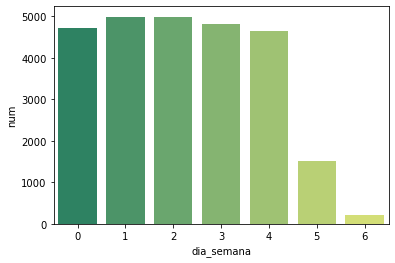

In [63]:
sns.barplot(data=df_cl_dias, x='dia_semana', y='num', palette='summer')

### 8.B Afluencia de Clientes por Hora<a name="afluencia-cl-hora"></a>

In [64]:
# Horas de más afluencia
df_cl_hora = df_n_fact.pivot_table('num', index='hora', aggfunc={'num':'nunique' }) 
df_cl_hora = df_cl_hora.reset_index()
df_cl_hora

,hora,num
0,0,190
1,1,10
2,2,10
3,3,8
4,4,14
5,5,12
6,6,15
7,7,74
8,8,2396
9,9,4012


<AxesSubplot:xlabel='hora', ylabel='num'>

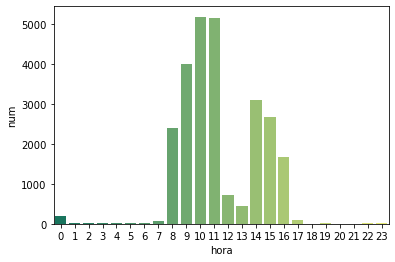

In [65]:
sns.barplot(data=df_cl_hora, x='hora', y='num', palette='summer')

In [66]:
# Horas de más afluencia entre semana

df_cl_hora_sin_we = df_n_fact.query('dia_semana < 5')

df_cl_hora_sin_we = df_cl_hora_sin_we.pivot_table('num', index='hora', aggfunc={'num':'nunique' }) 
df_cl_hora_sin_we = df_cl_hora_sin_we.reset_index()
df_cl_hora_sin_we

,hora,num
0,0,180
1,1,10
2,2,10
3,3,8
4,4,14
5,5,8
6,6,4
7,7,68
8,8,2172
9,9,3645


<AxesSubplot:xlabel='hora', ylabel='num'>

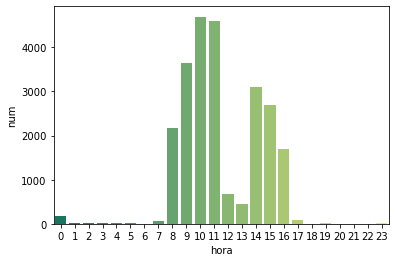

In [67]:
sns.barplot(data=df_cl_hora_sin_we, x='hora', y='num', palette='summer')

### 8.C Conclusiones<a name="afluencia-cl-conclusion"></a>

1. En promedio, se hacen 41 ventas al día (número de facturas): 43 en días de semana y 23 los fines de semana. Aproximadamente 6 facturas por hora (43 / 7 por las 7 horas que abre la tienda cada día)
2. Martes y miércoles son los días de mayor afluencia de clientes, seguido del lunes
3. A partir del jueves, la afluencia disminuye, en particular el fin de semana
4. Las horas de mayor afluencia son entre las 10am y las 12pm, y en la tarde de 2pm a 3pm

**Es recomendable garantizar la presencia y disponibilidad de todo el personal los lunes, martes y miércoles y en particular todos los días de 10am a 12pm**